In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
T = 100
n = 10
alpha = 0.9
beta = 0.2
gamma = 0.1
Lambda = [1,5]
cpd_z = [1-alpha,alpha,0.5]
Gamma = np.array(
    [
        [1-gamma,0,gamma],
        [0,1-gamma,gamma],
        [beta/2,beta/2,1-beta]
    ]
)



In [6]:
# Since numpy doesn't have built in support for categorical distribution
def categorical(distribution: np.array):
    # returns the result of a single sample drawn from a binomial distribution <distribution> 
    sample = np.random.multinomial(1,distribution)
    res = np.where(sample)[0][0]
    return res

In [7]:
# Simulate

C = np.zeros(T,dtype='int32')
Z = np.zeros((T,n),dtype='int32')
X = np.zeros((T,n),dtype='int32')
C[0] = 2
for t in range(T):
    if t == 0:
        pass
    else:
        C[t] = categorical(Gamma[C[t-1]])
    Z[t] = np.random.binomial(1,cpd_z[C[t]],size=n)
    for i in range(n):
        X[t][i] = np.random.poisson(Lambda[Z[t][i]])

    


Text(0.5, 0, 't')

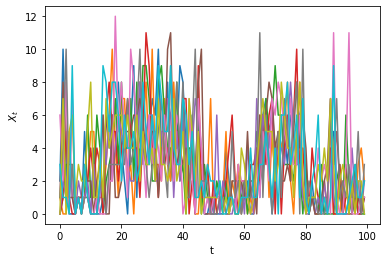

In [8]:
for i in range(n):
    plt.plot(X[0:,i])
plt.ylabel(r'$X_{t}$')
plt.xlabel('t')


In [9]:
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0).fit(X,C)


In [10]:
C

array([2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [11]:
coin = lambda p, size=None: np.random.binomial(1, p, size=size)
poisson = lambda p, x : np.exp(-p)*(p**x)/np.math.factorial(x)

px = np.array([[poisson(p_,x_) for p_ in (1,5)] for x_ in range(20)])
px

T = 100
n = 10
alpha = 0.9
beta = 0.2
gamma = 0.1
Lambda = [1,5]
cpd_z = np.array([
    [alpha, 1-alpha],
    [1-alpha,     alpha],
    [0.5, 0.5]
    ])

Gamma = np.array(
    [
        [1-gamma,0,gamma],
        [0,1-gamma,gamma],
        [beta/2,beta/2,1-beta]
    ]
)

In [12]:
%%latex
$$\psi^t = \psi(C^t,C^{t+1}) = P(C^{t+1}|C^t) = \Gamma $$
$$\phi_i^t = \sum_{Z_i^t}\psi(C^t,Z_i^t,X_i^t) = \sum{Z_i^t}P(Z_i^t|C^t)P(x_i^t|Z_i^t)$$
$$\tau^t = \sum_{C^{t-i}} \psi^{t-1}\tau^{t-1}\prod_{i=1}^n \phi_i^{t-1}$$
$$\tau_0 = P(C_0) = [0,0,1]$$
$$\theta^t = \psi^{t-1}\tau^{t-1}\prod_{i=1}^n \phi_i^{t-1}$$

<IPython.core.display.Latex object>

In [13]:
c = np.zeros(T)

taus = np.zeros((T,3))
tau = np.array([0,0,1])
taus[0] = tau
thetas = np.zeros((T,3,3))

for t in range(1,T):
    # multiply incoming messages (phi)
    phi = 1
    for i in range(0,n):
        phi *= px[X[t][i]]
    # this step is equivalent to marginalizing
    phi = cpd_z @ phi
    # calculate theta and store
    theta = Gamma * tau * phi
    thetas[t] = theta
    # calculate tau by marginalizing C
    tau = np.sum(theta,axis=1)
    # normalize tau
    tau /= np.sum(tau)
    taus[t] = tau
    


In [ ]:
# backwards pass 
taus_ = np.zeros((T,3))
tau_ = np.sum(thetas[T-1],axis=1)
tau_ /= np.sum(tau_)
taus_[T-1] = tau_
betas = np.zeros((T,3,3))
cpd_cs = np.zeros((T,3))
cpd_cs[0] = [0,0,1]
z_inf = np.zeros((T,n,2))
for t in range(T-1,0,-1):
    # multiply incoming messages (phi)
    beta = thetas[t]*tau_
    betas[t] = beta
    # marginalize
    cpd_c = np.sum(betas[t],axis=1)
    cpd_c /= np.sum(cpd_c)
    cpd_cs[t] = cpd_c
    # calculate tau_
    tau_ = cpd_c
    taus_[t] = tau_
    for i in range(n):
        l = ((cpd_z*px[X[t,i]]).T)
        r = (taus_[t].reshape(3,1))
        o = l@r
        z_inf[t][i] = o.reshape(2)/sum(o)

In [15]:
cpd_cs[np.arange(len(cpd_cs)),C]

array([1.        , 0.8       , 0.77574929, 0.74904597, 0.70641931,
       0.55425606, 0.76883571, 0.84117522, 0.86774791, 0.87808251,
       0.88339225, 0.88475447, 0.87636463, 0.18772766, 0.48978257,
       0.50724044, 0.70659917, 0.81969972, 0.85960038, 0.87551017,
       0.88242515, 0.88557367, 0.88704104, 0.8877327 , 0.88806051,
       0.88821628, 0.8882904 , 0.88832568, 0.88834248, 0.88835048,
       0.8883543 , 0.88835611, 0.88835698, 0.88835739, 0.88835758,
       0.88835768, 0.88835772, 0.8883577 , 0.88835737, 0.88835406,
       0.88832224, 0.11048296, 0.11293031, 0.13574429, 0.30132536,
       0.33211867, 0.50852488, 0.33370253, 0.67337244, 0.80869287,
       0.85549011, 0.87378993, 0.88165686, 0.88521898, 0.88687455,
       0.8876535 , 0.88801862, 0.8881959 , 0.88827656, 0.88827958,
       0.88794195, 0.88453974, 0.85303824, 0.63404228, 0.63526639,
       0.58842722, 0.77996875, 0.84508257, 0.86952881, 0.87977661,
       0.88435624, 0.886471  , 0.88746335, 0.88793226, 0.88815